In [1]:
from platform import python_version

print(python_version())

3.12.8


In [2]:
import random
random.seed(0)

In [3]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import v2

In [4]:
DATASET_PATH = './knee-osteoarthritis'

In [5]:
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'
AUTO_TEST_PATH = f'{DATASET_PATH}/auto_test'

In [6]:
transform_toTensor = transforms.Compose([transforms.ToTensor()])

In [7]:
train = torchvision.datasets.ImageFolder(TRAIN_PATH, transform_toTensor)
val = torchvision.datasets.ImageFolder(VAL_PATH, transform_toTensor)

In [8]:
print(len(train))
print(len(val))
# print(len(test))
# print(len(auto_test))

5778
826


### Augmentation 

In [9]:
import cv2
import numpy as np

#### Edges

In [10]:
sobel_y_1 = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
])
sobel_y_2 = sobel_y_1 * -1

def getAugmentationEdges(image):
    grayscaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply two filters, upper and lower for different bones
    edges_1 = cv2.filter2D(grayscaled, -1, sobel_y_1)
    edges_2 = cv2.filter2D(grayscaled, -1, sobel_y_2)

    # Cutout noisy background 
    _, edges_1 = cv2.threshold(edges_1, 10, 255, cv2.THRESH_TOZERO)
    _, edges_2 = cv2.threshold(edges_2, 10, 255, cv2.THRESH_TOZERO)

    edges = edges_1 + edges_2

    max_brightness = edges.max()

    # Normalize color
    edges = cv2.convertScaleAbs(edges, alpha = 255/max_brightness, beta = 0)

    return edges

### Building Dataset

In [11]:
example_img = train[0][0]
# print(example_img)
print(example_img.shape)

torch.Size([3, 224, 224])


In [12]:
transform_baseImage = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(256),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
])

transform_edgesImage = v2.Compose([
    v2.ToDtype(torch.float),
    v2.Normalize(mean=[0.449], std=[0.226])
])

In [13]:

from torch.utils.data import Dataset, DataLoader

class KneeOsteoarthritis(Dataset):
    def __init__(self, dataset):
        self.images = []
        self.edges_images = []
        self.labels = []
        
        for data in dataset:
            image = data[0]
            image_agmentation = image.numpy()*255
            image_agmentation = np.moveaxis(image_agmentation, 0, -1)
            edges_image = getAugmentationEdges(image_agmentation)
            # print(image.shape, image_agmentation.shape, edges_image.shape)
            edges_image = torch.tensor(edges_image)
            label = data[1]
            
            image = transform_baseImage(image)
            # print(image.shape, edges_image.shape)
            edges_image = transform_edgesImage(edges_image.unsqueeze(0))
            
            self.images.append(image)
            self.edges_images.append(edges_image)            
            self.labels.append(label)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        edges_image = self.edges_images[idx]
        label = self.labels[idx]
        
        return image, edges_image, label

In [14]:
train_dataset = KneeOsteoarthritis(train)
val_dataset = KneeOsteoarthritis(val)
# test_dataset = KneeOsteoarthritis(test)
# auto_test_dataset = KneeOsteoarthritis(auto_test)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.7358838].


torch.Size([3, 256, 256]) torch.Size([1, 224, 224])


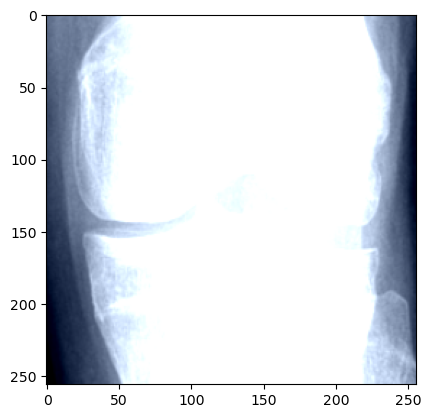

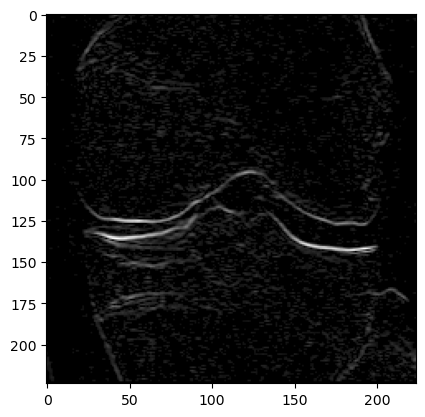

In [16]:
row = train_dataset[1]
normal_ex = row[0]
augmented_ex = row[1]
print(normal_ex.shape, augmented_ex.shape)


imshow(normal_ex)
imshow(augmented_ex)

### Configuring loader

In [17]:
from collections import Counter

In [18]:

def get_Class_Frequency(dataset):
  freq_table = dict(Counter(dataset.labels))
  return freq_table

In [19]:
BATCH_SIZE = 128

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Building Model

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [45]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18, ResNet18_Weights

class AugmentedModel(nn.Module):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()
        
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False)
        
        self.baseClassifier = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout * 0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout* 0.7),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, image: torch.Tensor, edges: torch.Tensor) -> torch.Tensor:
        
        images = self.resnet18(image)
        images = self.baseClassifier(images)
        return images

net = AugmentedModel(3, 0.5)
net = net.to(device)

### Freeze Resnet

In [46]:
for param in net.resnet18.parameters():
  param.requires_grad = False

In [47]:
print(sum(p.numel() for p in net.parameters()))

trainable_parameters = filter(lambda p: p.requires_grad, net.parameters())
print(sum(p.numel() for p in trainable_parameters))

12374699
685187


### Setting up Model Training

In [48]:
import torch.optim as optim
# criterion = nn.NLLLoss()

class_weights = get_Class_Frequency(train_dataset)
weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
print(weights_tensor, weights_tensor.dtype)

criterion = nn.CrossEntropyLoss(weights_tensor)
optimizer = optim.Adam(net.parameters(), lr=0.001)

tensor([2286., 3319.,  173.], device='cuda:0') torch.float32


In [49]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [50]:
def validate(model):
  with torch.no_grad():
    epoch_correct = 0
    epoch_samples = 0
    epoch_batches = 0
    running_loss = 0.0
    
    for i, data in enumerate(val_loader):
      images, edges, labels = data
      images = images.to(device)
      edges = edges.to(device)
      labels = labels.to(device)
      
      # forward + backward + optimize
      outputs = model(images, edges)
      loss = criterion(outputs, labels)
      
      # Changing outputs (logits) to labels
      outputs_clear = outputs.max(1).indices
      
      epoch_correct += (outputs_clear == labels).float().sum()
      epoch_samples += len(outputs)
      
      epoch_batches += 1
      
      running_loss += loss.item()
    
    # print(epoch_correct, epoch_samples)
    accuracy = epoch_correct / epoch_samples * 100
    loss = running_loss / epoch_batches
    
    return accuracy, loss
    

In [51]:
EXP_NAME = "only-resnet18/1"

In [52]:
from torch.utils.tensorboard import SummaryWriter

logger = SummaryWriter(log_dir=f"logs/{EXP_NAME}")

In [53]:
epochCounter = 0

In [54]:

def train_many(model, epochs_nr, regularization_type = "L2", lambda_reg=0.01):
    global epochCounter
    
    for epoch in range(0, epochs_nr):  # loop over the dataset multiple times
        epoch_correct = 0
        epoch_samples = 0
        epoch_batches = 0
        running_loss = 0.0
    
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            images, edges, labels = data
            images = images.to(device)
            edges = edges.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(images, edges)
            loss = criterion(outputs, labels)
            
            # Apply L1 regularization
            if regularization_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * l1_norm
                
            # Apply L2 regularization
            elif regularization_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm
                
            loss.backward()
            
            optimizer.step()
            
            # Changing outputs (logits) to labels
            outputs_clear = outputs.max(1).indices
            
            epoch_correct += (outputs_clear == labels).float().sum()
            epoch_samples += len(outputs)
            epoch_batches +=1
            
            running_loss += loss.item()
        
        tAccuracy = epoch_correct / epoch_samples * 100
        tLoss = running_loss / epoch_batches
        
        # Validation
        vAccuracy, vLoss = validate(model)
        
        logger.add_text("REGULARIZATION_TYPE", regularization_type, global_step=epochCounter)
        logger.add_scalar("REGULARIZATION_LAMBDA", lambda_reg, global_step=epochCounter)
        logger.add_scalar("learning_rate", get_lr(optimizer), global_step=epochCounter)
        
        logger.add_scalar("Accuracy/train", tAccuracy, global_step=epochCounter)
        logger.add_scalar("Loss/train", tLoss, global_step=epochCounter)
        logger.add_scalar("Accuracy/validation", vAccuracy, global_step=epochCounter)
        logger.add_scalar("Loss/validation", vLoss, global_step=epochCounter)
        
        print(f'Epoch {epochCounter}: Training: accuracy: {tAccuracy:.3f}%, loss: {tLoss:.3f}; Validation: accuracy: {vAccuracy:.3f}%, loss: {vLoss:.3f}')
        
        epochCounter += 1
        
    print('Finished Training')

### Training Model

In [55]:
train_many(net, 15, 'L2', 0.001)

Epoch 0: Training: accuracy: 54.656%, loss: 10.694; Validation: accuracy: 56.659%, loss: 0.646
Epoch 1: Training: accuracy: 57.736%, loss: 10.491; Validation: accuracy: 56.659%, loss: 0.627
Epoch 2: Training: accuracy: 58.740%, loss: 10.430; Validation: accuracy: 58.717%, loss: 0.659
Epoch 3: Training: accuracy: 60.159%, loss: 10.392; Validation: accuracy: 56.538%, loss: 0.625
Epoch 4: Training: accuracy: 60.661%, loss: 10.378; Validation: accuracy: 58.596%, loss: 0.639
Epoch 5: Training: accuracy: 62.011%, loss: 10.365; Validation: accuracy: 56.416%, loss: 0.668
Epoch 6: Training: accuracy: 61.613%, loss: 10.362; Validation: accuracy: 61.138%, loss: 0.615
Epoch 7: Training: accuracy: 62.755%, loss: 10.358; Validation: accuracy: 61.622%, loss: 0.607
Epoch 8: Training: accuracy: 62.807%, loss: 10.346; Validation: accuracy: 61.380%, loss: 0.643
Epoch 9: Training: accuracy: 64.036%, loss: 10.337; Validation: accuracy: 61.864%, loss: 0.606
Epoch 10: Training: accuracy: 64.469%, loss: 10.33